In [1]:
import glob 
import os
from langchain_community.llms import Ollama
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image

In [2]:
def find_data(CK=False, JAFFE=False, FER2013=False, neutral=False):

    emo_dict = {"anger":0, "contempt":0, "disgust":0, "fear":0, "happiness":0, "neutral":0, "sadness":0, "surprise":0}
    list_paths = []

    # CK+ load
    if CK:
        for emotion in ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]:
            if emotion is "neutral" and not neutral:
                continue
            emo_folder_path = "../Polygence/Datasets/CK+/" + emotion
            for pic_file in glob.glob(os.path.join(emo_folder_path, "*png")):
                list_paths.append([emotion, pic_file])

    # JAFFE load
    if JAFFE:
        for pic_file in glob.glob(os.path.join("../Polygence/Datasets/JAFFE", "*tiff")):
            if "AN" in pic_file[26:]:
                list_paths.append(["anger", pic_file])
            elif "DI" in pic_file[26:]:
                list_paths.append(["disgust", pic_file])
            elif "FE" in pic_file[26:]:
                list_paths.append(["fear", pic_file])
            elif "HA" in pic_file[26:]:
                list_paths.append(["happiness", pic_file])
            elif "NE" in pic_file[26:]:
                list_paths.append(["neutral", pic_file])
            elif "SA" in pic_file[26:]:
                list_paths.append(["sadness", pic_file])
            else:
                list_paths.append(["surprise", pic_file])

    #FER-2013
    if FER2013:
        FER_emo_dict = {0:"anger", 1:"disgust", 2:"fear", 3:"happiness", 4:"neutral", 5:"sadness", 6:"surprise"}
        for set in ["test/", "train/"]:
            root = "../Polygence/Datasets/FER2013/" + set
            for index, emotion in enumerate(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]):
                emo_folder_path = root + emotion
                for pic_file in glob.glob(os.path.join(emo_folder_path, "*jpg")):
                    list_paths.append([FER_emo_dict[index], pic_file])   
    for (a,b) in list_paths:
        emo_dict[a] +=1
    print(emo_dict)
    return list_paths

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/d6/73t68jg509l9qqjp_k_6st940000gq/T/ipykernel_1614/3529465164.py:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if emotion is "neutral" and not neutral:


In [3]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image

def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str
def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

In [7]:
# First working model
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


CK = find_data(CK=True, JAFFE=False, FER2013=False, neutral=False)

sample_path = CK[216][1] # Weakest is sadness at 0%
sample = Image.open(sample_path)
sample_b64 = convert_to_base64(sample)

print(CK[216][0])

bakllava = Ollama(model="bakllava")

examples = [
    {
        "question": f"""Answer the question based only on the following image:
    {sample_b64}
    Question: Choose the answer that best represents the emotion on the person's face in the picture:
    0: anger
    1: contempt
    2: disgust
    3: fear
    4: happiness
    5: sadness
    6: surprise""",
        "answer": """5""",
    },
]

example_prompt = PromptTemplate(
    input_variables=["question", "answer"], template="Question: {question}\n{answer}"
)

prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="{input}",
    input_variables=["input"],
)
output_parser = StrOutputParser()

chain = prompt | bakllava | output_parser


file_path = CK[220][1]
print(CK[220][0])
pil_image = Image.open(file_path)
image_b64 = convert_to_base64(pil_image)
#plt_img_base64(image_b64)

input = f"""Answer the question based only on the following image:
    {image_b64}
    Question: Choose the answer that best represents the emotion on the person's face in the picture:
    0: anger
    1: contempt
    2: disgust
    3: fear
    4: happiness
    5: sadness
    6: surprise"""

print(chain.invoke({"input": input}))

{'anger': 45, 'contempt': 18, 'disgust': 59, 'fear': 25, 'happiness': 69, 'neutral': 0, 'sadness': 28, 'surprise': 83}
sadness
sadness
0


In [9]:
#Function
def help(path, chain):

    file_path = path
    #print(CK[100][0])
    pil_image = Image.open(file_path)
    image_b64 = convert_to_base64(pil_image)
    #plt_img_base64(image_b64)
    input = f"""Answer the question based only on the following image:
        {image_b64}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise"""

    return chain.invoke({"input": input})

In [10]:
#Function Controller

from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


CK = find_data(CK=True, JAFFE=False, FER2013=False, neutral=False)

sample_path = CK[216][1] # Weakest is sadness at 0%
sample = Image.open(sample_path)
sample_b64 = convert_to_base64(sample)

print(CK[216][0])

bakllava = Ollama(model="bakllava")

examples = [
    {
        "question": f"""Answer the question based only on the following image:
        {sample_b64}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise""",
        "answer": """5""",
    },
]

example_prompt = PromptTemplate(
    input_variables=["question", "answer"], template="Question: {question}\n{answer}"
)

prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="{input}",
    input_variables=["input"],
)
output_parser = StrOutputParser()

chain = prompt | bakllava | output_parser




emo_dict = {"anger":0, "contempt":1, "disgust":2, "fear":3, "happiness":4, "sadness":5, "surprise":6}
heat_matrix = [[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]

correct = 0
total = 0

for emo, path in CK:
    emo_hat = help(path, chain)
    if emo_hat in [str(i) for i in range(7)]: 
        heat_matrix[emo_dict[emo]][int(emo_hat)] +=1
        if int(emo_hat)==emo_dict[emo]:
            correct +=1
    total +=1 
    print(emo, emo_hat)
    if total%10==0:
        print(total, correct/total)

{'anger': 45, 'contempt': 18, 'disgust': 59, 'fear': 25, 'happiness': 69, 'neutral': 0, 'sadness': 28, 'surprise': 83}
sadness
anger 3
anger 3
anger 4
anger 4
anger 0
anger 3
anger 3
anger 3
anger 4
anger 3
10 0.1
anger 3
anger 4
anger 0
anger 0
anger 3
anger 3
anger 0
anger 4
anger 4
anger 4
20 0.2
anger 4
anger 3
anger 0
anger 3
anger 4
anger 4
anger 4
anger 4
anger 4
anger 4
30 0.16666666666666666
anger 0
anger 4
anger 4
anger 4
anger 4
anger 2
anger 4
anger 4
anger 0
anger 0
40 0.2
anger 4
anger 4
anger 4
anger 0
anger 4
contempt 4
contempt 4
contempt 0
contempt 0
contempt 3
50 0.18
contempt 4
contempt 3
contempt 0
contempt 3
contempt 4
contempt 1
contempt 0
contempt 4
contempt 4
contempt 4
60 0.16666666666666666
contempt 3
contempt 0
contempt 4: happiness
disgust 4
disgust 3
disgust 0
disgust 4
disgust 0
disgust 3
disgust 2
70 0.15714285714285714
disgust 4
disgust 4
disgust 4
disgust 0
disgust 3
disgust 4
disgust 0
disgust 4
disgust 3
disgust 4
80 0.1375
disgust 4
disgust 4
disgus

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=False,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.1%}".format(value) for value in cf.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = 0.152

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = (12,9)

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

[[0.2   0.    0.022 0.244 0.533 0.    0.   ]
 [0.277 0.055 0.    0.222 0.388 0.    0.   ]
 [0.203 0.016 0.05  0.186 0.508 0.    0.016]
 [0.16  0.08  0.12  0.16  0.48  0.    0.   ]
 [0.115 0.072 0.086 0.231 0.449 0.    0.028]
 [0.071 0.142 0.035 0.178 0.5   0.035 0.   ]
 [0.108 0.012 0.024 0.192 0.65  0.    0.012]]


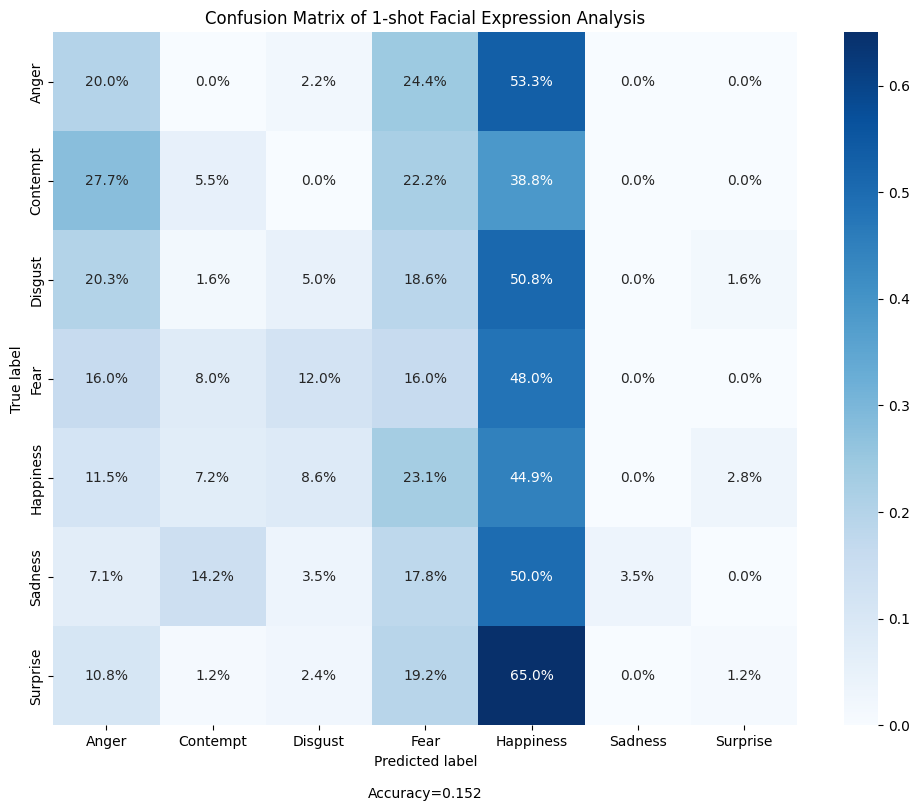

In [45]:
heatmap_matrix = [[truncate(m/counts[n],3) for m in i] for n,i in enumerate(heat_matrix)]
make_confusion_matrix(np.array(heatmap_matrix), title="Confusion Matrix of 1-shot Facial Expression Analysis", categories=["Anger", "Contempt", "Disgust", "Fear", "Happiness", "Sadness", "Surprise"])

print(np.array(heatmap_matrix))

In [ ]:
CK = find_data(CK=True)
emo_dict = {"anger":0, "contempt":1, "disgust":2, "fear":3, "happiness":4, "sadness":5, "surprise":6}
heat_matrix = [[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]

correct = 0
total = 0

for emo, path in CK:
    emo_hat = help(path)
    if emo_hat in [str(i) for i in range(7)]: 
        heat_matrix[emo_dict[emo]][int(emo_hat)] +=1
        if int(emo_hat)==emo_dict[emo]:
            correct +=1
    total +=1 
    print(emo, emo_hat)

In [11]:
#one-shot results
def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

counts = [45, 18, 59,25,69,28,83]
for n, i in enumerate(heat_matrix):
    print([truncate(m/counts[n],3) for m in i]) 


print(correct, total, truncate(correct/total, 3)) 



[0.2, 0.0, 0.022, 0.244, 0.533, 0.0, 0.0]
[0.277, 0.055, 0.0, 0.222, 0.388, 0.0, 0.0]
[0.203, 0.016, 0.05, 0.186, 0.508, 0.0, 0.016]
[0.16, 0.08, 0.12, 0.16, 0.48, 0.0, 0.0]
[0.115, 0.072, 0.086, 0.231, 0.449, 0.0, 0.028]
[0.071, 0.142, 0.035, 0.178, 0.5, 0.035, 0.0]
[0.108, 0.012, 0.024, 0.192, 0.65, 0.0, 0.012]
50 327 0.152


In [48]:
totals = [0,0,0,0,0,0,0]
for i in heat_matrix:
    totals = [a+b for (a,b) in list(zip(totals, i))]
print(totals)
print(heat_matrix)

[49, 14, 16, 67, 172, 1, 4]
[[9, 0, 1, 11, 24, 0, 0], [5, 1, 0, 4, 7, 0, 0], [12, 1, 3, 11, 30, 0, 1], [4, 2, 3, 4, 12, 0, 0], [8, 5, 6, 16, 31, 0, 2], [2, 4, 1, 5, 14, 1, 0], [9, 1, 2, 16, 54, 0, 1]]


In [46]:
print(prompt.invoke(input))

text="Question: Answer the question based only on the following image:\n        /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAHqAoABAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AMOw1wx6W8R8XfZ8rxD/AGbvz7bsVzQuM6t5v244z/r/ACf/AGWu3tvEhjt1T/hP/KA/g/sfdj8cVS13XTdWoT/hM/t3H+r/ALL8r9cVxUsm5yfN3e+3FRE++aKSnwNsuEbfswfvYzj8K7OXWs6QIv8AhLt3rb/2bj/x7Fc9pV0sGpGU6l9k5z53keZ+O2tzxDrJu7UJ/wAJUNRG3/V/2f5X64ql4U1EWEjH+3zpWTy32Pz6Z4j1I3t0x/t0akM/eFp5P6YrA3cfe/Sm0Va0ybyNSjk+0/Zcf8tdm/b+Heuq13W/tWnxR/8ACWC+wuBD/ZvlbfbOK47d3z+GKbnmkzxRRS0d60/D9wLW+Mjal/Z//TXyPN/StbxVqv8AaA58SHVcAAf6D5H9BT/CmrfYI/8AkZv7KPp9g8/+lZPiC9+2Xm/+1f7Q+b/WfZ/J/Sul0jXRb6d5X/CaC0O3AgbS/MH0Jwazbu98xJCN